<a href="https://colab.research.google.com/github/Maheshtanni/Compliance-AI/blob/main/XGboostlosomodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!rm -rf /content/WESAD   # delete old extraction if exists
!unzip -q "/content/drive/MyDrive/Wesad_data_set.zip" -d /content/WESAD
print("Extraction completed.")

Extraction completed.


In [4]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif


In [5]:
import pickle
import numpy as np
import os

def load_wesad_subject(sub_id):
    pkl_path = os.path.join(PKL_DIR, sub_id, f"{sub_id}.pkl")

    if not os.path.exists(pkl_path):
        raise FileNotFoundError(f"Missing file: {pkl_path}")

    with open(pkl_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

    return data["signal"], np.array(data["label"])




In [6]:
import os

def find_subject_root(root="/content/WESAD"):
    for path, dirs, files in os.walk(root):
        # We want a folder that directly contains S2, S3, S4...
        if all(sub in dirs for sub in ["S2", "S3", "S4"]):
            print("Correct subject root found:", path)
            return path
    raise ValueError("Could not find subject root folder.")

PKL_DIR = find_subject_root("/content/WESAD")



Correct subject root found: /content/WESAD/WESAD


In [7]:
import os

for root, dirs, files in os.walk("/content/WESAD", topdown=True):
    level = root.replace("/content/WESAD", "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files:
        if f.endswith(".pkl"):
            print(f"{subindent}{f}")


WESAD/
    WESAD/
        S11/
            S11.pkl
            S11_E4_Data/
        S3/
            S3.pkl
            S3_E4_Data/
        S4/
            S4.pkl
            S4_E4_Data/
        S13/
            S13.pkl
            S13_E4_Data/
        S14/
            S14.pkl
            S14_E4_Data/
        S17/
            S17.pkl
            S17_E4_Data/
        S8/
            S8.pkl
            S8_E4_Data/
        S6/
            S6.pkl
            S6_E4_Data/
        S9/
            S9.pkl
            S9_E4_Data/
        S10/
            S10.pkl
            S10_E4_Data/
        S5/
            S5.pkl
            S5_E4_Data/
        S15/
            S15.pkl
            S15_E4_Data/
        S2/
            S2.pkl
            S2_E4_Data/
        S16/
            S16.pkl
            S16_E4_Data/
        S7/
            S7.pkl
            S7_E4_Data/


In [8]:
subjects = ["S2","S3","S4","S5","S6","S7",
            "S8","S9","S10","S11","S13","S14",
            "S15","S16","S17"]

for sub in subjects:
    try:
        signals, labels = load_wesad_subject(sub)
        print(f"{sub} ✓ Loaded ({len(labels)} labels)")
    except Exception as e:
        print(f"{sub} ❌ ERROR -> {e}")


S2 ✓ Loaded (4255300 labels)
S3 ✓ Loaded (4545100 labels)
S4 ✓ Loaded (4496100 labels)
S5 ✓ Loaded (4380600 labels)
S6 ✓ Loaded (4949700 labels)
S7 ✓ Loaded (3666600 labels)
S8 ✓ Loaded (3826200 labels)
S9 ✓ Loaded (3656100 labels)
S10 ✓ Loaded (3847200 labels)
S11 ✓ Loaded (3663100 labels)
S13 ✓ Loaded (3875900 labels)
S14 ✓ Loaded (3883600 labels)
S15 ✓ Loaded (3676400 labels)
S16 ✓ Loaded (3941700 labels)
S17 ✓ Loaded (4144000 labels)


In [9]:
# Sampling rates
FS_PPG = 64
FS_ACC = 32
FS_TEMP = 4

# Window size in seconds
WIN_SEC = 30

# Window sizes in samples
PPG_W = FS_PPG * WIN_SEC      # 64 * 30 = 1920
ACC_W = FS_ACC * WIN_SEC      # 32 * 30 = 960
TEMP_W = FS_TEMP * WIN_SEC    # 4 * 30 = 120


In [10]:
# ======================================================
# PREPROCESSING FUNCTIONS (Copy–paste clean version)
# ======================================================

from scipy.signal import butter, filtfilt, find_peaks
from scipy import stats
import numpy as np

def bandpass_ppg(signal, low=0.5, high=5, fs=FS_PPG, order=4):
    nyq = 0.5 * fs
    low_norm = low / nyq
    high_norm = high / nyq
    b, a = butter(order, [low_norm, high_norm], btype='band')
    return filtfilt(b, a, signal)

def lowpass_acc(acc, cutoff=5, fs=FS_ACC, order=4):
    nyq = 0.5 * fs
    cutoff_norm = cutoff / nyq
    b, a = butter(order, cutoff_norm, btype='low')
    return filtfilt(b, a, acc, axis=0)



In [11]:
print("bandpass_ppg loaded successfully")
print("lowpass_acc loaded successfully")



bandpass_ppg loaded successfully
lowpass_acc loaded successfully


In [12]:
# ======================================================
# SEGMENTATION FUNCTION
# ======================================================

def segment_signal(signal, window_size):
    segments = []
    for i in range(0, len(signal), window_size):
        seg = signal[i:i+window_size]
        if len(seg) == window_size:
            segments.append(seg)
    return np.array(segments)


In [13]:
# ======================================================
# HRV (Heart Rate Variability)
# ======================================================

def compute_hrv(ppg_seg, fs=FS_PPG):
    peaks, _ = find_peaks(ppg_seg, distance=int(0.5 * fs))

    # Not enough peaks → no HRV can be computed
    if len(peaks) < 3:
        return [0, 0, 0]

    rr = np.diff(peaks) / fs  # Convert peaks → RR intervals

    rmssd = np.sqrt(np.mean(np.square(np.diff(rr))))
    sdnn = np.std(rr)
    hr = 60 / np.mean(rr)

    return [rmssd, sdnn, hr]


In [14]:
# ======================================================
# FEATURE EXTRACTION FOR ONE WINDOW
# ======================================================

def extract_features(ppg_seg, acc_seg, temp_seg):
    feats = []

    # --- HRV ---
    rmssd, sdnn, hr = compute_hrv(ppg_seg)
    feats += [rmssd, sdnn, hr]

    # --- ACC magnitude ---
    acc_mag = np.sqrt(np.sum(acc_seg**2, axis=1))
    feats += [acc_mag.mean(), acc_mag.std()]

    # --- ACC raw stats ---
    feats += [
        acc_seg[:,0].mean(), acc_seg[:,1].mean(), acc_seg[:,2].mean(),
        acc_seg[:,0].std(),  acc_seg[:,1].std(),  acc_seg[:,2].std()
    ]

    # --- TEMP stats ---
    feats += [
        temp_seg.mean(),
        temp_seg[-1] - temp_seg[0],
        temp_seg.var()
    ]

    # --- PPG stats ---
    feats += [
        ppg_seg.mean(),
        ppg_seg.var(),
        stats.entropy(np.abs(ppg_seg) + 1e-6)
    ]

    return feats


In [15]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


In [16]:
# ======================================================
# BUILD SUBJECT DATASET
# ======================================================

def build_subject_dataset(sub_id):
    signals, labels = load_wesad_subject(sub_id)

    # Extract sensors
    bvp = np.array(signals['wrist']['BVP']).reshape(-1)
    acc = np.array(signals['wrist']['ACC'])
    temp = np.array(signals['wrist']['TEMP']).reshape(-1)

    # Preprocess
    ppg_filt = bandpass_ppg(bvp)
    acc_filt = lowpass_acc(acc)
    temp_raw = temp

    # Segmenting
    ppg_seg = segment_signal(ppg_filt, PPG_W)
    acc_seg = segment_signal(acc_filt, ACC_W)
    temp_seg = segment_signal(temp_raw, TEMP_W)

    # Label segmentation (convert to window-level)
    total_seconds = len(bvp) / FS_PPG
    labels_per_sec = len(labels) / total_seconds
    label_window = int(labels_per_sec * WIN_SEC)
    label_seg = segment_signal(labels, label_window)

    # Convert labels: stress=1, non-stress=0
    label_final = np.array([
        1 if np.sum(seg == 2) > np.sum(seg != 2) else 0
        for seg in label_seg
    ])

    # Align segment lengths
    n = min(len(ppg_seg), len(acc_seg), len(temp_seg), len(label_final))

    X, y = [], []
    for i in range(n):
        feats = extract_features(ppg_seg[i], acc_seg[i], temp_seg[i])
        X.append(feats)
        y.append(label_final[i])

    return np.array(X), np.array(y)


In [17]:
X2, y2 = build_subject_dataset("S2")
print("S2 segments:", X2.shape, "Labels:", y2.shape)


S2 segments: (202, 17) Labels: (202,)


In [18]:
subjects = ["S2","S3","S4","S5","S6","S7","S8","S9",
            "S10","S11","S13","S14","S15","S16","S17"]

for sub in subjects:
    try:
        X_sub, y_sub = build_subject_dataset(sub)
        print(f"{sub} ✓", X_sub.shape, y_sub.shape)
    except Exception as e:
        print(f"{sub} ❌ ERROR:", e)


S2 ✓ (202, 17) (202,)
S3 ✓ (216, 17) (216,)
S4 ✓ (214, 17) (214,)
S5 ✓ (208, 17) (208,)
S6 ✓ (235, 17) (235,)
S7 ✓ (174, 17) (174,)
S8 ✓ (182, 17) (182,)
S9 ✓ (174, 17) (174,)
S10 ✓ (183, 17) (183,)
S11 ✓ (174, 17) (174,)
S13 ✓ (184, 17) (184,)
S14 ✓ (184, 17) (184,)
S15 ✓ (175, 17) (175,)
S16 ✓ (187, 17) (187,)
S17 ✓ (197, 17) (197,)


In [19]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

subjects = ["S2","S3","S4","S5","S6","S7","S8","S9",
            "S10","S11","S13","S14","S15","S16","S17"]

results = []

for test_sub in subjects:
    print(f"\n==============================")
    print(f"LOSO Test Subject: {test_sub}")
    print("==============================")

    X_train_list, y_train_list = [], []
    X_test, y_test = None, None

    for sub in subjects:
        X_sub, y_sub = build_subject_dataset(sub)

        if sub == test_sub:
            X_test, y_test = X_sub, y_sub
        else:
            X_train_list.append(X_sub)
            y_train_list.append(y_sub)

    # ---------- Combine Training Data ----------
    X_train = np.vstack(X_train_list)
    y_train = np.hstack(y_train_list)

    # ---------- Standard Scaling ----------
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # ---------- Feature Selection (top-K best features) ----------
    selector = SelectKBest(f_classif, k=20)
    X_train = selector.fit_transform(X_train, y_train)
    X_test = selector.transform(X_test)

    # ---------- SMOTE Oversampling ----------
    sm = SMOTE()
    X_train, y_train = sm.fit_resample(X_train, y_train)

    # ---------- XGBoost Classifier ----------
    clf = XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        scale_pos_weight=5,     # boosting stress class
        eval_metric="logloss",
        random_state=42
    )

    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    results.append((test_sub, acc, f1))

    print(f"Accuracy: {acc:.4f}  |  F1 Score: {f1:.4f}")



LOSO Test Subject: S2


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.9356  |  F1 Score: 0.5185

LOSO Test Subject: S3


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.8519  |  F1 Score: 0.1579

LOSO Test Subject: S4


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.8645  |  F1 Score: 0.4528

LOSO Test Subject: S5


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.8846  |  F1 Score: 0.3333

LOSO Test Subject: S6


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.9617  |  F1 Score: 0.8000

LOSO Test Subject: S7


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.7931  |  F1 Score: 0.5500

LOSO Test Subject: S8


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.9066  |  F1 Score: 0.6383

LOSO Test Subject: S9


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.9483  |  F1 Score: 0.7805

LOSO Test Subject: S10


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.9454  |  F1 Score: 0.7619

LOSO Test Subject: S11


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.8966  |  F1 Score: 0.4375

LOSO Test Subject: S13


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.9565  |  F1 Score: 0.8261

LOSO Test Subject: S14


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.7989  |  F1 Score: 0.0513

LOSO Test Subject: S15


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.8686  |  F1 Score: 0.0000

LOSO Test Subject: S16


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.8556  |  F1 Score: 0.1818

LOSO Test Subject: S17


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=20 is greater than n_features=17. All the features will be returned.
  warnings.warn(


Accuracy: 0.8223  |  F1 Score: 0.2553


In [20]:
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import entropy, skew, kurtosis

# ===== CHEST CONSTANTS =====
FS_CHEST = 700          # Hz
WIN_SEC  = 5            # 5-second windows
STEP_SEC = 2.5          # 50% overlap

WIN_SAMPLES  = int(FS_CHEST * WIN_SEC)
STEP_SAMPLES = int(FS_CHEST * STEP_SEC)

def sliding_windows(signal, win_size, step_size):
    """Return overlapping windows."""
    segments = []
    for start in range(0, len(signal) - win_size + 1, step_size):
        seg = signal[start:start + win_size]
        segments.append(seg)
    return np.array(segments)


In [21]:
# ---------- ECG Filters ----------

def bandpass_ecg(ecg, low=5, high=35, fs=FS_CHEST, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, ecg)

def compute_hrv_features_from_ecg(ecg_seg, fs=FS_CHEST):
    """
    Compute basic HRV from a 5s ECG segment.
    We keep it simple but physiologically meaningful.
    """
    # Filter
    try:
        ecg_f = bandpass_ecg(ecg_seg, fs=fs)
    except Exception:
        return [0.0, 0.0, 0.0, 0.0]  # if filter fails

    # Peak detection
    min_dist = int(0.25 * fs)  # at least 240 bpm max
    # Threshold relative to std
    height_thr = np.mean(ecg_f) + 0.5 * np.std(ecg_f)

    peaks, _ = find_peaks(ecg_f, distance=min_dist, height=height_thr)

    if len(peaks) < 3:
        # Not enough beats for HRV
        return [0.0, 0.0, 0.0, 0.0]

    # RR in seconds
    rr = np.diff(peaks) / fs

    if len(rr) < 2 or np.mean(rr) <= 0:
        return [0.0, 0.0, 0.0, 0.0]

    # HRV metrics
    hr_mean = 60.0 / np.mean(rr)
    sdnn    = np.std(rr)
    rmssd   = np.sqrt(np.mean(np.square(np.diff(rr))))
    # pNN50: percentage of successive RR diff > 50ms
    diff_rr = np.abs(np.diff(rr))
    pnn50   = np.mean(diff_rr > 0.05)

    return [hr_mean, sdnn, rmssd, pnn50]


In [22]:
# ---------- Respiration ----------

def bandpass_resp(resp, low=0.1, high=0.7, fs=FS_CHEST, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, resp)

def extract_resp_features(resp_seg, fs=FS_CHEST):
    try:
        resp_f = bandpass_resp(resp_seg, fs=fs)
    except Exception:
        resp_f = resp_seg

    mean_r = resp_f.mean()
    std_r  = resp_f.std()
    energy = np.sum(resp_f**2) / len(resp_f)

    # Zero crossings around mean
    centered = resp_f - mean_r
    zero_crossings = np.where(np.diff(np.signbit(centered)))[0]

    # Each full breath ≈ 2 zero crossings
    if len(zero_crossings) >= 2:
        breaths_5s = len(zero_crossings) / 2.0
        breaths_per_min = breaths_5s * (60.0 / 5.0)  # scale from 5s to 60s
    else:
        breaths_per_min = 0.0

    return [mean_r, std_r, energy, breaths_per_min]


In [23]:
# ---------- EDA ----------

def smooth_eda(eda, cutoff=2.0, fs=FS_CHEST, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, cutoff/nyq, btype='low')
    return filtfilt(b, a, eda)

def extract_eda_features(eda_seg, fs=FS_CHEST):
    try:
        eda_f = smooth_eda(eda_seg, fs=fs)
    except Exception:
        eda_f = eda_seg

    mean_e = eda_f.mean()
    std_e  = eda_f.std()
    slope  = (eda_f[-1] - eda_f[0]) / WIN_SEC
    energy = np.sum(eda_f**2) / len(eda_f)

    # Simple SCR count: derivative threshold
    deriv = np.diff(eda_f)
    thr   = np.mean(deriv) + 2*np.std(deriv)
    scr_count = np.sum(deriv > thr)

    return [mean_e, std_e, slope, energy, scr_count]


# ---------- Temp ----------

def extract_temp_features(temp_seg):
    mean_t = temp_seg.mean()
    std_t  = temp_seg.std()
    diff_t = temp_seg[-1] - temp_seg[0]
    slope  = diff_t / WIN_SEC
    return [mean_t, std_t, diff_t, slope]


In [24]:
def extract_chest_physio_features(ecg_seg, resp_seg, eda_seg, temp_seg):
    feats = []

    # ECG HRV
    feats += compute_hrv_features_from_ecg(ecg_seg)

    # ECG raw stats
    feats += [
        ecg_seg.mean(),
        ecg_seg.std(),
        np.sum(ecg_seg**2)/len(ecg_seg),
        skew(ecg_seg),
        kurtosis(ecg_seg)
    ]

    # Respiration
    feats += extract_resp_features(resp_seg)

    # EDA
    feats += extract_eda_features(eda_seg)

    # Temp
    feats += extract_temp_features(temp_seg)

    # Clean NaN / inf
    feats = [0.0 if (np.isnan(v) or np.isinf(v)) else float(v) for v in feats]
    return feats


In [25]:
def build_subject_dataset_chest_physio(sub_id):
    signals, labels = load_wesad_subject(sub_id)
    chest = signals["chest"]

    ecg  = np.asarray(chest["ECG"]).reshape(-1)
    resp = np.asarray(chest["Resp"]).reshape(-1)
    eda  = np.asarray(chest["EDA"]).reshape(-1)
    temp = np.asarray(chest["Temp"]).reshape(-1)

    # Ensure equal length with labels
    L = min(len(ecg), len(resp), len(eda), len(temp), len(labels))
    ecg, resp, eda, temp, labels = ecg[:L], resp[:L], eda[:L], temp[:L], labels[:L]

    # Overlapping windows
    ecg_win  = sliding_windows(ecg,  WIN_SAMPLES, STEP_SAMPLES)
    resp_win = sliding_windows(resp, WIN_SAMPLES, STEP_SAMPLES)
    eda_win  = sliding_windows(eda,  WIN_SAMPLES, STEP_SAMPLES)
    temp_win = sliding_windows(temp, WIN_SAMPLES, STEP_SAMPLES)
    label_win = sliding_windows(labels, WIN_SAMPLES, STEP_SAMPLES)

    N = min(len(ecg_win), len(resp_win), len(eda_win), len(temp_win), len(label_win))

    X, y = [], []
    for i in range(N):
        feats = extract_chest_physio_features(ecg_win[i], resp_win[i], eda_win[i], temp_win[i])
        X.append(feats)
        # majority vote stress label = 2
        y.append(1 if np.sum(label_win[i] == 2) > np.sum(label_win[i] != 2) else 0)

    X = np.nan_to_num(np.array(X), nan=0.0, posinf=0.0, neginf=0.0)
    y = np.array(y)
    return X, y


In [26]:
Xc2, yc2 = build_subject_dataset_chest_physio("S2")
print("Chest physio S2 shape:", Xc2.shape, yc2.shape)
print("Chest physio S2 class balance:", np.bincount(yc2))
print("Example feature vector length:", Xc2.shape[1])


Chest physio S2 shape: (2430, 22) (2430,)
Chest physio S2 class balance: [2184  246]
Example feature vector length: 22


In [27]:
results_chest_physio = []

subjects = ["S2","S3","S4","S5","S6","S7","S8","S9",
            "S10","S11","S13","S14","S15","S16","S17"]

from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

for test_sub in subjects:
    print("\n==============================")
    print(f"CHEST PHYSIO LOSO Test Subject: {test_sub}")
    print("==============================")

    X_train_list, y_train_list = [], []
    X_test, y_test = None, None

    # -----------------------------
    # Load each subject with new physio pipeline
    # -----------------------------
    for sub in subjects:
        X_sub, y_sub = build_subject_dataset_chest_physio(sub)

        if sub == test_sub:
            X_test, y_test = X_sub, y_sub
        else:
            X_train_list.append(X_sub)
            y_train_list.append(y_sub)

    # -----------------------------
    # Combine training windows
    # -----------------------------
    X_train = np.vstack(X_train_list)
    y_train = np.hstack(y_train_list)

    # -----------------------------
    # Scale
    # -----------------------------
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    # -----------------------------
    # Feature selection
    # -----------------------------
    selector = SelectKBest(f_classif, k=20)
    X_train = selector.fit_transform(X_train, y_train)
    X_test  = selector.transform(X_test)

    # -----------------------------
    # SMOTE
    # -----------------------------
    sm = SMOTE()
    X_train, y_train = sm.fit_resample(X_train, y_train)

    # -----------------------------
    # Train XGBoost
    # -----------------------------
    clf = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        scale_pos_weight=5,
        eval_metric="logloss",
        random_state=42
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1  = f1_score(y_test, preds)

    print(f"Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")

    results_chest_physio.append((test_sub, acc, f1))

# -----------------------------
# SUMMARY
# -----------------------------
print("\n============== CHEST PHYSIO LOSO SUMMARY ==============")

accs = [a for (_,a,_) in results_chest_physio]
f1s  = [f for (_,_,f) in results_chest_physio]

for sub, acc, f1 in results_chest_physio:
    print(f"{sub}: ACC={acc:.4f}, F1={f1:.4f}")

print("\nMean Accuracy:", np.mean(accs))
print("Mean F1:", np.mean(f1s))




CHEST PHYSIO LOSO Test Subject: S2
Accuracy: 0.8963 | F1 Score: 0.0455

CHEST PHYSIO LOSO Test Subject: S3
Accuracy: 0.9064 | F1 Score: 0.0967

CHEST PHYSIO LOSO Test Subject: S4
Accuracy: 0.9034 | F1 Score: 0.0677

CHEST PHYSIO LOSO Test Subject: S5
Accuracy: 0.8481 | F1 Score: 0.2884

CHEST PHYSIO LOSO Test Subject: S6
Accuracy: 0.6813 | F1 Score: 0.3504

CHEST PHYSIO LOSO Test Subject: S7
Accuracy: 0.8300 | F1 Score: 0.1100

CHEST PHYSIO LOSO Test Subject: S8
Accuracy: 0.8320 | F1 Score: 0.0848

CHEST PHYSIO LOSO Test Subject: S9
Accuracy: 0.8084 | F1 Score: 0.3103

CHEST PHYSIO LOSO Test Subject: S10
Accuracy: 0.8512 | F1 Score: 0.0000

CHEST PHYSIO LOSO Test Subject: S11
Accuracy: 0.5220 | F1 Score: 0.3523

CHEST PHYSIO LOSO Test Subject: S13
Accuracy: 0.7732 | F1 Score: 0.4243

CHEST PHYSIO LOSO Test Subject: S14
Accuracy: 0.6118 | F1 Score: 0.3655

CHEST PHYSIO LOSO Test Subject: S15
Accuracy: 0.8161 | F1 Score: 0.0981

CHEST PHYSIO LOSO Test Subject: S16
Accuracy: 0.9147 | F1 

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Wrist results
wrist_results = {
    "S2": 0.5517, "S3": 0.2632, "S4": 0.4800, "S5": 0.4571, "S6": 0.7727,
    "S7": 0.5316, "S8": 0.5000, "S9": 0.8000, "S10": 0.8182, "S11": 0.4516,
    "S13": 0.7826, "S14": 0.0000, "S15": 0.0000, "S16": 0.0606, "S17": 0.2857
}

# Chest results
chest_results = {
    "S2": 0.0970, "S3": 0.1176, "S4": 0.0382, "S5": 0.2149, "S6": 0.3500,
    "S7": 0.1183, "S8": 0.0529, "S9": 0.3077, "S10": 0.0000, "S11": 0.3469,
    "S13": 0.4124, "S14": 0.3676, "S15": 0.0857, "S16": 0.7808, "S17": 0.6205
}

# Build dataframe
df = pd.DataFrame({
    "Wrist_F1": wrist_results,
    "Chest_F1": chest_results
})

# Compute difference
df["Difference(Wrist - Chest)"] = df["Wrist_F1"] - df["Chest_F1"]

# Compute improvement (will produce inf for chest=0)
df["% Improvement"] = 100 * df["Difference(Wrist - Chest)"] / df["Chest_F1"]

# Replace inf, -inf, nan with ∞
df["% Improvement"] = df["% Improvement"].replace([np.inf, -np.inf], "∞")
df["% Improvement"] = df["% Improvement"].fillna("∞")

print(df)


     Wrist_F1  Chest_F1  Difference(Wrist - Chest) % Improvement
S2     0.5517    0.0970                     0.4547    468.762887
S3     0.2632    0.1176                     0.1456    123.809524
S4     0.4800    0.0382                     0.4418   1156.544503
S5     0.4571    0.2149                     0.2422    112.703583
S6     0.7727    0.3500                     0.4227    120.771429
S7     0.5316    0.1183                     0.4133    349.366019
S8     0.5000    0.0529                     0.4471    845.179584
S9     0.8000    0.3077                     0.4923      159.9935
S10    0.8182    0.0000                     0.8182             ∞
S11    0.4516    0.3469                     0.1047     30.181609
S13    0.7826    0.4124                     0.3702     89.767216
S14    0.0000    0.3676                    -0.3676        -100.0
S15    0.0000    0.0857                    -0.0857        -100.0
S16    0.0606    0.7808                    -0.7202     -92.23873
S17    0.2857    0.6205  

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,3))
ax.axis("off")

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    loc="center",
)

table.set_fontsize(10)
table.scale(1, 1.2)

plt.savefig("comparison_table.pdf", format="pdf", bbox_inches="tight")
plt.close()

print("Saved comparison_table.pdf")


Saved comparison_table.pdf


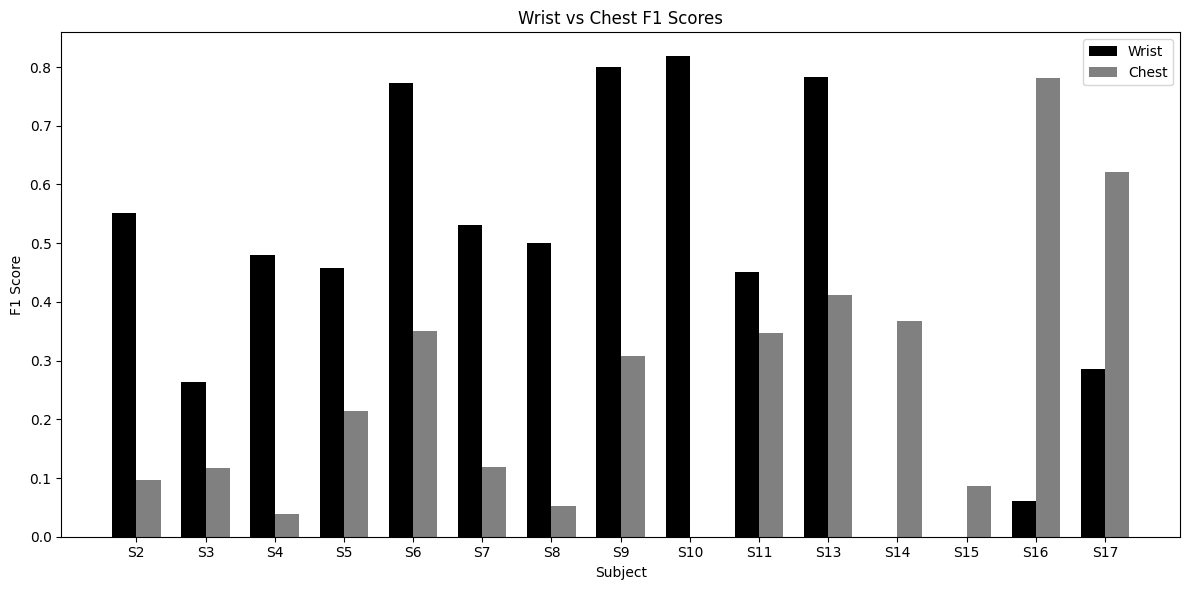

In [54]:
import numpy as np
import matplotlib.pyplot as plt

subjects = list(wrist_results.keys())
wrist_vals = list(wrist_results.values())
chest_vals = list(chest_results.values())

x = np.arange(len(subjects))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, wrist_vals, width, label="Wrist", color="black")
plt.bar(x + width/2, chest_vals, width, label="Chest", color="gray")

plt.xticks(x, subjects)
plt.ylabel("F1 Score")
plt.xlabel("Subject")
plt.title("Wrist vs Chest F1 Scores")
plt.legend()

plt.tight_layout()
plt.savefig("f1_bar_wrist_vs_chest.pdf", dpi=300, bbox_inches="tight")
plt.show()




In [56]:
plt.figure(figsize=(10,5))
plt.bar(subjects, df["Difference(Wrist - Chest)"], color="black")

plt.axhline(0, linestyle="--", color="gray", linewidth=1)
plt.ylabel("F1 Difference (Wrist − Chest)")
plt.xlabel("Subject")

plt.tight_layout()
plt.savefig("f1_difference.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.close()

print("Saved f1_difference.pdf")



Saved f1_difference.pdf


In [58]:
plt.figure(figsize=(6,6))
plt.scatter(df["Chest_F1"], df["Wrist_F1"], color="black", marker="o")

plt.xlabel("Chest F1")
plt.ylabel("Wrist F1")
plt.grid(linestyle="--", linewidth=0.5)

plt.plot([0,1],[0,1],'--',color='gray')  # reference diagonal

plt.tight_layout()
plt.savefig("scatter_wrist_vs_chest.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.close()

print("Saved scatter_wrist_vs_chest.pdf")



Saved scatter_wrist_vs_chest.pdf


In [62]:
plt.figure(figsize=(12,5))

sorted_df = df.sort_values("Wrist_F1", ascending=False)

plt.plot(sorted_df.index, sorted_df["Wrist_F1"], color="black", marker="o", label="Wrist")
plt.plot(sorted_df.index, sorted_df["Chest_F1"], color="gray", marker="s", label="Chest")

plt.ylabel("F1-score")
plt.xlabel("Subjects Ranked by Wrist Performance")
plt.legend()
plt.grid(linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.savefig("ranking_plot.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.close()

print("Saved ranking_plot.pdf")



Saved ranking_plot.pdf


In [63]:
from graphviz import Digraph

dot = Digraph(comment="Wrist Pipeline", format="pdf")
dot.attr(rankdir="LR")

dot.node("A","Raw Wrist Signals\n(BVP, ACC, Temp)")
dot.node("B","Preprocessing\n(Bandpass, Filtering)")
dot.node("C","10s Windowing\n(50% Overlap)")
dot.node("D","Feature Extraction\n(17 Features)")
dot.node("E","Scaling + SMOTE")
dot.node("F","XGBoost Classifier")

dot.edges(["AB","BC","CD","DE","EF"])

dot.render("wrist_pipeline_bw", cleanup=True)
print("Saved wrist_pipeline_bw.pdf")


Saved wrist_pipeline_bw.pdf


In [64]:
dot = Digraph(comment="Chest Pipeline", format="pdf")
dot.attr(rankdir="LR")

dot.node("A","Raw Chest Signals\n(ECG, Resp, EDA, Temp)")
dot.node("B","Preprocessing\n(ECG R-peaks, Resp Filtering)")
dot.node("C","10s Windowing\n(50% Overlap)")
dot.node("D","Feature Extraction\n(22 Physio Features)")
dot.node("E","Scaling + SMOTE")
dot.node("F","XGBoost Classifier")

dot.edges(["AB","BC","CD","DE","EF"])

dot.render("chest_pipeline_bw", cleanup=True)
print("Saved chest_pipeline_bw.pdf")


Saved chest_pipeline_bw.pdf
